# Recommender System - Baseline Model

In [75]:
import os
import math
import random
import numpy as np
import pandas as pd
import csv
import gc
import time
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from recommenders.datasets.python_splitters import python_chrono_split, python_stratified_split

os.environ["KAGGLEHUB_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"

import kagglehub
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from tensorboardX import SummaryWriter

In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is Douban Cross Domain dataset from Kaggle.

In [3]:
DOUBAN_DATASET = r"fengzhujoey/douban-datasetratingreviewside-information"
DOUBAN_DOMAIN = "moviereviews"

def load_douban_reviews(domain:str, max_items:int=100000) -> pd.DataFrame:
    path = kagglehub.dataset_download(DOUBAN_DATASET)
    df_raw = pd.read_csv(f"{path}/douban_dataset(text information)/{DOUBAN_DOMAIN}_cleaned.txt",
                         sep="\t",
                         quoting=csv.QUOTE_MINIMAL,
                         dtype=str,
                         keep_default_na=False)

    df_raw.columns = [c.strip().strip('"').strip('"') for c in df_raw.columns]

    # Coerce rating to float (invalid/missing -> 0.0)
    ratings = pd.to_numeric(df_raw["rating"], errors="coerce").fillna(0.0).astype(float)

    # Parse time to POSIX seconds (int)
    timestamp = pd.to_datetime(df_raw["time"], errors="coerce", utc=True)
    timestamp = timestamp.fillna(pd.Timestamp("1970-01-01", tz="UTC"))
    timestamp_s = (timestamp.astype(int) // 10**9).astype(int)

    out = pd.DataFrame({
        "user": df_raw["user_id"].astype(int),
        "item": df_raw["movie_id"].astype(int),
        "rating": ratings,
        "domain": domain,
        "timestamp": timestamp_s
    })

    if max_items:
        out = out.copy()
        out = out.sample(min(max_items, len(out))).reset_index(drop=True)

    return out

df = load_douban_reviews(DOUBAN_DOMAIN, max_items=None)
print(f"Loaded {len(df)} rows from {DOUBAN_DOMAIN} domain.")

Loaded 1278401 rows from moviereviews domain.


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [5]:
# Make implicit dataset, filter users/items with less than 5 interactions, and encode user/item IDs
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0

    # Filter users and items with less than 5 interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()

    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index

    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")

    user_enc = LabelEncoder()
    item_enc = LabelEncoder()

    df["user_id"] = user_enc.fit_transform(df["user"])
    df["item_id"] = item_enc.fit_transform(df["item"])

    return {"filtered_df": df,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

data_processor = preprocess_dataset(df, min_user_interactions=20, min_item_interactions=20)
filtered_df = data_processor["filtered_df"]

After interactions filtering: 1138509 rows, 2519 users, 9881 items


In [6]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.4f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.4f}")

calculate_data_sparsity(filtered_df)

Number of users: 2519
Number of items: 9881
Number of interactions: 1138509
------------------------------
Interaction Matrix Density: 0.0457
Interaction Matrix Sparsity: 0.9543


In [77]:
# Define Leave-One-Out (LOO) split
def loo_split(df):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []
    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 5:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]])  # Last interaction as test
        val_rows.append(g.iloc[[-2]])    # Second last interaction as validation
        train_rows.append(g.iloc[:-2])    # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    return train_df, val_df, test_df

def create_data_splits(df, train_size=0.9):
    train, temp = python_chrono_split(
        df, ratio=train_size, filter_by="user",
        col_user="user_id", col_item="item_id", col_timestamp="timestamp"
    )

    val, test = python_stratified_split(
        temp, ratio=0.5, filter_by="user",
        col_user="user_id", col_item="item_id"
    )

    print(f"Train set size: {train.shape[0]}")
    print(f"Validation set size: {val.shape[0]}")
    print(f"Test set size: {test.shape[0]}")
    print(f"Common users in train and val: {len(set(train['user_id']).intersection(set(val['user_id'])))}")
    print(f"Common users in train and test: {len(set(train['user_id']).intersection(set(test['user_id'])))}")

    return train, val, test

# train_df, val_df, test_df = loo_split(filtered_df)
train_df, val_df, test_df = create_data_splits(filtered_df)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train set size: 1024668
Validation set size: 56972
Test set size: 56869
Common users in train and val: 2519
Common users in train and test: 2519
Train/Validation/Test split: 1024668, 56972, 56869


## Building the dataset with negative sampling

In [78]:
NUM_USERS = filtered_df["user_id"].max() + 1
NUM_ITEMS = filtered_df["item_id"].max() + 1

In [79]:
# Rank the single positive against k negative samples for evaluation
pos_items_by_user = defaultdict(set)
for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
    pos_items_by_user[u].add(i)

def sample_eval_negatives(eval_df, num_items, pos_by_user, n_neg=99, seed=42):
    rng = np.random.default_rng(seed)
    neg_dict = {}
    for u, pos_i in zip(eval_df["user_id"].values, eval_df["item_id"].values):
        user_pos = pos_by_user[u].copy()
        user_pos.add(pos_i)
        candidates = []
        while len(candidates) < n_neg:
            cand = rng.integers(0, num_items)
            if cand not in user_pos:
                candidates.append(int(cand))
                user_pos.add(cand)
        neg_dict[u] = candidates
    return neg_dict

val_negatives = sample_eval_negatives(val_df, NUM_ITEMS, pos_items_by_user)
test_negatives = sample_eval_negatives(test_df, NUM_ITEMS, pos_items_by_user)
print(f"Sampled {len(val_negatives)} validation users and {len(test_negatives)} test users with {len(next(iter(val_negatives.values())))} negatives each.")

Sampled 2519 validation users and 2519 test users with 99 negatives each.


In [80]:
# Training dataset with k negatives per positive
class ImplicitTrainingDataset(Dataset):
    def __init__(self, train_df, num_items, pos_by_user, neg_k=4):
        self.pos_pairs = train_df[["user_id", "item_id"]].values.astype(np.int64)
        self.num_pos = len(self.pos_pairs)
        self.neg_k = neg_k
        self.num_items = num_items
        self.pos_by_user = pos_by_user
        self.length = self.num_pos * (1 + self.neg_k)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        pos_idx = idx // (self.neg_k + 1)
        is_pos = (idx % (self.neg_k + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = random.randint(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

train_dataset = ImplicitTrainingDataset(train_df,
                                  num_items=NUM_ITEMS,
                                  pos_by_user=pos_items_by_user,
                                  neg_k=4)
train_loader = DataLoader(train_dataset,
                          batch_size=1024,
                          shuffle=True)

print(f"Training dataset created with {len(train_dataset)} samples.")

Training dataset created with 5123340 samples.


## Utility functions for evaluation & ranking metrics
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, Recall@K

In [81]:
# @torch.no_grad()
# def compute_val_loss(model, eval_df, loss_fn, pos_items_by_user, num_items, neg_k=4, device="cpu"):
#     model.eval()
#     losses = []
#     for u, i_pos in zip(eval_df["user_id"].values, eval_df["item_d"].values):
#         # Positives
#         u_t = torch.tensor([u], dtype=torch.long, device=device)
#         i_t = torch.tensor([i_pos], dtype=torch.long, device=device)
#         logit_pos = model(u_t, i_t)
#         loss_pos = loss_fn(logit_pos, torch.ones_like(logit_pos))
#         losses.append(loss_pos.item())
#
#         # Negatives
#         taken = pos_items_by_user[u].copy()
#         taken.add(int(i_pos))
#         n_added = 0
#         while n_added < neg_k:
#             j = random.randint(0, num_items - 1)
#             if j not in taken:
#                 uj = torch.tensor([u], dtype=torch.long, device=device)
#                 jj = torch.tensor([j], dtype=torch.long, device=device)
#                 logit_neg = model(uj, jj)
#                 loss_neg = loss_fn(logit_neg, torch.zeros_like(logit_neg))
#                 losses.append(loss_neg.item())
#                 taken.add(j)
#                 n_added += 1
#
#     return float(np.mean(losses))
#
# def evaluate_ranking(eval_df, n_neg, seed=42):
#     rng = np.random.default_rng(seed)
#     neg_dict = {}
#

In [87]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_ranking(model, eval_df, neg_dict, k=10, device="cpu"):
    model.eval()
    hits, ndcgs, precisions, recalls = [], [], [], []

    for u, pos_i in zip(eval_df["user_id"].values, eval_df["item_id"].values):
        candidates = [int(pos_i)] + neg_dict[u]
        users = torch.tensor([u] * len(candidates), dtype=torch.long, device=device)
        items = torch.tensor(candidates, dtype=torch.long, device=device)

        scores = model(users, items).detach().cpu().numpy()
        rank = np.argsort(-scores).tolist().index(0) + 1

        hit = 1.0 if rank <= k else 0.0
        hits.append(hit)
        ndcg = (1.0 / math.log2(rank + 1)) if rank <= k else 0.0
        ndcgs.append(ndcg)
        precisions.append(hit / k)
        recalls.append(hit)

    return {
        "HR@K": float(np.mean(hits)),
        "NDCG@K": float(np.mean(ndcgs)),
        "Precision@K": float(np.mean(precisions)),
        "Recall@K": float(np.mean(recalls))
    }

@torch.no_grad()
def compute_val_loss(model, eval_df, loss_fn, pos_items_by_user, num_items, neg_k=4, device="cpu"):
    model.eval()
    losses = []
    for u, i_pos in tqdm(zip(eval_df["user_id"].values, eval_df["item_id"].values), total=len(eval_df), desc="Validation loss", leave=True):
        # Positives
        u_t = torch.tensor([u], dtype=torch.long, device=device)
        i_t = torch.tensor([i_pos], dtype=torch.long, device=device)
        logit_pos = model(u_t, i_t)
        loss_pos = loss_fn(logit_pos, torch.ones_like(logit_pos))
        losses.append(loss_pos.item())

        # Negatives
        taken = pos_items_by_user[u].copy()
        taken.add(int(i_pos))
        n_added = 0
        while n_added < neg_k:
            j = random.randint(0, num_items - 1)
            if j not in taken:
                jj = torch.tensor([j], dtype=torch.long, device=device)
                logit_neg = model(u_t, jj)
                loss_neg = loss_fn(logit_neg, torch.zeros_like(logit_neg))
                losses.append(loss_neg.item())
                taken.add(j)
                n_added += 1

    return float(np.mean(losses))

## Building baseline model

In [88]:
# Simple Matrix Factorization model with biases (dot product)
class MF(nn.Module):
    def __init__(self, num_users, num_items, embed_dim=64):
        super().__init__()
        self.user_emb = nn.Embedding(num_users, embed_dim)
        self.item_emb = nn.Embedding(num_items, embed_dim)
        # nn.init.xavier_uniform_(self.user_emb.weight)
        # nn.init.xavier_uniform_(self.item_emb.weight)
        nn.init.uniform_(self.user_emb.weight, 0.5, 1.0)
        nn.init.uniform_(self.item_emb.weight, 0.5, 1.0)
        self.linear = nn.Linear(embed_dim, 1)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_emb(user_ids)
        item_embeds = self.item_emb(item_ids)
        output = self.linear(user_embeds * item_embeds)
        return output.squeeze()

In [89]:
class MatrixFactorization(nn.Module):
    """Improved MF model with dropout and better initialization"""
    def __init__(self, n_users, n_items, embed_dim, dropout=0.2):
        super().__init__()
        self.user_emb = nn.Embedding(n_users, embed_dim)
        self.item_emb = nn.Embedding(n_items, embed_dim)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout(dropout)

        # Better initialization
        nn.init.xavier_uniform_(self.user_emb.weight)
        nn.init.xavier_uniform_(self.item_emb.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.dropout(self.user_emb(user_ids))
        item_embeds = self.dropout(self.item_emb(item_ids))
        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        output = dot_product + self.user_bias(user_ids) + self.item_bias(item_ids) + self.global_bias
        return output.squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embedding.num_embeddings).to(next(self.parameters()).device)
        user_embed = self.user_embedding(user_tensor)
        item_embeds = self.item_embedding(all_items)

        scores = torch.matmul(user_embed, item_embeds.T).squeeze()
        scores += self.user_bias(user_tensor).squeeze()
        scores += self.item_bias(all_items).squeeze()
        scores += self.global_bias
        return torch.sigmoid(scores)

## Train loop

In [90]:
def model_trainer(
        model,
        train_loader,
        eval_df,
        val_negatives,
        num_items,
        pos_items_by_user,
        epochs,
        lr=0.001,
        weight_decay=1e-5,
        k=10,
        neg_k=4,
        save_dir="model",
        device="cpu"):

    os.makedirs(save_dir, exist_ok=True)

    model.to(device)
    loss_fn = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    writer = SummaryWriter()

    train_losses = []
    val_losses = []
    val_metrics = []

    best_ndcg = 0.0
    best_epoch = 0

    # Training loop
    for epoch in range(0, epochs):
        model.train()
        running_loss = 0.0
        n_batches = 0
        start_time = time.time()

        # Training batch loop
        for users, items, labels in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            users = users.to(DEVICE)
            items = items.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()
            logits = model(users, items)
            loss = loss_fn(logits, labels)

            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            n_batches += 1

        # Calculate average training loss for the epoch
        train_loss = running_loss / max(n_batches, 1)
        train_losses.append(train_loss)

        # Validation loss and metrics
        val_loss = compute_val_loss(model, eval_df, loss_fn, pos_items_by_user, num_items, neg_k=neg_k, device=device)
        val_losses.append(val_loss)
        metrics = evaluate_ranking(model, eval_df, val_negatives, k=k, device=device)
        val_metrics.append(metrics)

        hr = metrics["HR@K"]
        ndcg = metrics["NDCG@K"]
        precision = metrics["Precision@K"]
        recall = metrics["Recall@K"]

        # Check for improvement
        improvement_msg = ""
        if ndcg > best_ndcg:
            improvement_msg = f"\nNew best NDCG@{k}: {ndcg:.4f}"
            best_ndcg = ndcg
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # Logging to TensorBoard
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", val_loss, epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", hr, epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", ndcg, epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", precision, epoch)
        writer.add_scalar(f"Metrics/Val_Recall@{k}", recall, epoch)

        epoch_time = time.time() - start_time

        print(f"Epoch {epoch + 1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"HR@{k}: {hr:.4f}, "
              f"NDCG@{k}: {ndcg:.4f}, "
              f"Precision@{k}: {precision:.4f}, "
              f"Recall@{k}: {recall:.4f}, "
              f"Time: {epoch_time:.2f}s"
              f"{improvement_msg}\n")

    print("\n" + "="*50)
    print("Training Complete!")
    print(f"Best performance was at Epoch {best_epoch} with NDCG@{k}: {best_ndcg:.4f}")
    print("="*50)

    # Clean up
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()

    return train_losses, val_losses, val_metrics, best_ndcg

In [91]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embed_dim=64).to(DEVICE)
# model = MF(num_users=NUM_USERS, num_items=NUM_ITEMS, embed_dim=32).to(DEVICE)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_df=val_df,
    val_negatives=val_negatives,
    num_items=NUM_ITEMS,
    pos_items_by_user=pos_items_by_user,
    epochs=10,
    lr=0.0001,
    weight_decay=5e-3,
    k=10,                         # Cutoff for ranking metrics
    neg_k=4,
    device=DEVICE
)

Validation loss: 100%|██████████| 56972/56972 [02:46<00:00, 342.07it/s]


Epoch 1/10 - Train Loss: 0.6229, Val Loss: 0.5738, HR@10: 0.4215, NDCG@10: 0.2285, Precision@10: 0.0421, Recall@10: 0.4215, Time: 230.65s
New best NDCG@10: 0.2285



Validation loss: 100%|██████████| 56972/56972 [02:48<00:00, 338.54it/s]


Epoch 2/10 - Train Loss: 0.5429, Val Loss: 0.5195, HR@10: 0.4217, NDCG@10: 0.2295, Precision@10: 0.0422, Recall@10: 0.4217, Time: 233.86s
New best NDCG@10: 0.2295



Validation loss: 100%|██████████| 56972/56972 [02:45<00:00, 343.30it/s]


Epoch 3/10 - Train Loss: 0.5077, Val Loss: 0.5011, HR@10: 0.4438, NDCG@10: 0.2367, Precision@10: 0.0444, Recall@10: 0.4438, Time: 230.67s
New best NDCG@10: 0.2367



Validation loss: 100%|██████████| 56972/56972 [02:48<00:00, 337.66it/s]


Epoch 4/10 - Train Loss: 0.4997, Val Loss: 0.4996, HR@10: 0.4425, NDCG@10: 0.2375, Precision@10: 0.0443, Recall@10: 0.4425, Time: 233.01s
New best NDCG@10: 0.2375



Validation loss: 100%|██████████| 56972/56972 [02:47<00:00, 339.80it/s]


Epoch 5/10 - Train Loss: 0.4994, Val Loss: 0.4997, HR@10: 0.4273, NDCG@10: 0.2349, Precision@10: 0.0427, Recall@10: 0.4273, Time: 232.55s



Validation loss: 100%|██████████| 56972/56972 [02:46<00:00, 342.20it/s]


Epoch 6/10 - Train Loss: 0.4994, Val Loss: 0.4997, HR@10: 0.4274, NDCG@10: 0.2327, Precision@10: 0.0427, Recall@10: 0.4274, Time: 231.51s



Validation loss: 100%|██████████| 56972/56972 [02:47<00:00, 340.47it/s]


Epoch 7/10 - Train Loss: 0.4994, Val Loss: 0.4997, HR@10: 0.4299, NDCG@10: 0.2336, Precision@10: 0.0430, Recall@10: 0.4299, Time: 231.39s



Validation loss: 100%|██████████| 56972/56972 [02:44<00:00, 345.34it/s]


Epoch 8/10 - Train Loss: 0.4994, Val Loss: 0.4997, HR@10: 0.4325, NDCG@10: 0.2348, Precision@10: 0.0433, Recall@10: 0.4325, Time: 228.43s



Validation loss: 100%|██████████| 56972/56972 [03:05<00:00, 306.35it/s]


Epoch 9/10 - Train Loss: 0.4994, Val Loss: 0.4996, HR@10: 0.4375, NDCG@10: 0.2363, Precision@10: 0.0437, Recall@10: 0.4375, Time: 254.27s



Validation loss: 100%|██████████| 56972/56972 [02:57<00:00, 321.12it/s]


Epoch 10/10 - Train Loss: 0.4994, Val Loss: 0.4997, HR@10: 0.4297, NDCG@10: 0.2338, Precision@10: 0.0430, Recall@10: 0.4297, Time: 242.89s


Training Complete!
Best performance was at Epoch 4 with NDCG@10: 0.2375


In [92]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    """Load best checkpoint into the provided model."""
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [93]:
def final_evaluation(model,
                     test_df,
                     test_negatives,
                     device,
                     k_values=(5, 10, 20, 50),
                     save_csv: str | None = None) -> pd.DataFrame:
    """
    Evaluate at multiple K and return a DataFrame with rows indexed by K.
    Assumes evaluate_ranking(model, eval_df, test_negatives, k, device) is defined.
    """
    rows = []
    for k in k_values:
        metrics = evaluate_ranking(model, test_df, test_negatives, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
            "Recall@K": metrics["Recall@K"],
        })

    results_df = pd.DataFrame(rows).set_index("K").sort_index()

    print(results_df.to_string(float_format=lambda x: f"{x:.4f}"))

    if save_csv is not None:
        results_df.to_csv(save_csv, index=True)

    return results_df

@torch.no_grad()
def get_recommendations(model, user_id, pos_items_by_user, data, top_k=10, exclude_interacted=True):
    """Get top-k recommendations for a user"""
    model.eval()
    scores = model.predict_all_items(user_id)

    # Exclude already interacted items
    if exclude_interacted and user_id in pos_items_by_user.keys():
        # Set scores of already interacted items to -inf
        interacted_items = list(pos_items_by_user[user_id])
        for item_id in interacted_items:
            scores[item_id] = -float('inf')

    # Get top-k items
    top_scores, top_indices = torch.topk(scores, top_k)

    recommendations = []
    for idx, score in zip(top_indices.cpu().numpy(), top_scores.cpu().numpy()):
        original_item = data["item_encoder"].inverse_transform([idx])[0]
        recommendations.append({
            "item_id": idx,
            "item": original_item,
            "score": float(score)
        })

    return recommendations

def show_sample_recommendations(model, data, pos_items_by_user, num_users=5, top_k=10):
    """Show sample recommendations for random users"""
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    # Get random users
    df = data["filtered_df"]
    user_candidates = df["user_id"].unique().tolist()
    n = min(num_users, len(user_candidates))
    sample_users = random.sample(user_candidates, n)

    for user_id in sample_users:
        original_user = data["user_encoder"].inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        # Get user's interaction history (last 5)
        user_items = list(pos_items_by_user[user_id])[:5]
        print("Recent interactions:")
        for item_id in user_items:
            original_item = data["item_encoder"].inverse_transform([item_id])[0]
            print(f"  - {original_item}")

        # Get recommendations
        recommendations = get_recommendations(model, user_id=user_id, pos_items_by_user=pos_items_by_user, data=data, top_k=top_k)
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [94]:
def plot_training_history(train_losses, val_losses, val_metrics, k=10, save_path="training_history.png"):
    """Plot training history including train/val loss and metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Training History", fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].plot(val_losses, label="Validation Loss", color="red")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@10
    hr_values = [m["HR@K"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label=f"Val HR@{k}", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel(f"HR@{k}")
    axes[0, 1].set_title(f"Validation Hit Rate@{k}")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@10
    ndcg_values = [m["NDCG@K"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label=f"Val NDCG@{k}", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel(f"NDCG@{k}")
    axes[0, 2].set_title(f"Validation NDCG@{k}")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@10
    precision_values = [m["Precision@K"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label=f"Val Precision@{k}", color="purple", marker="^")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel(f"Precision@{k}")
    axes[1, 0].set_title(f"Validation Precision@{k}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@10
    recall_values = [m["Recall@K"] for m in val_metrics]
    axes[1, 1].plot(recall_values, label=f"Val Recall@{k}", color="brown", marker="v")
    axes[1, 1].set_xlabel(f"Epoch")
    axes[1, 1].set_ylabel(f"Recall@{k}")
    axes[1, 1].set_title(f"Validation Recall@{k}")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label=f"HR@{k}", marker="o")
    axes[1, 2].plot(ndcg_values, label=f"NDCG@{k}", marker="s")
    axes[1, 2].plot(precision_values, label=f"Precision@{k}", marker="^")
    axes[1, 2].plot(recall_values, label=f"Recall@{k}", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

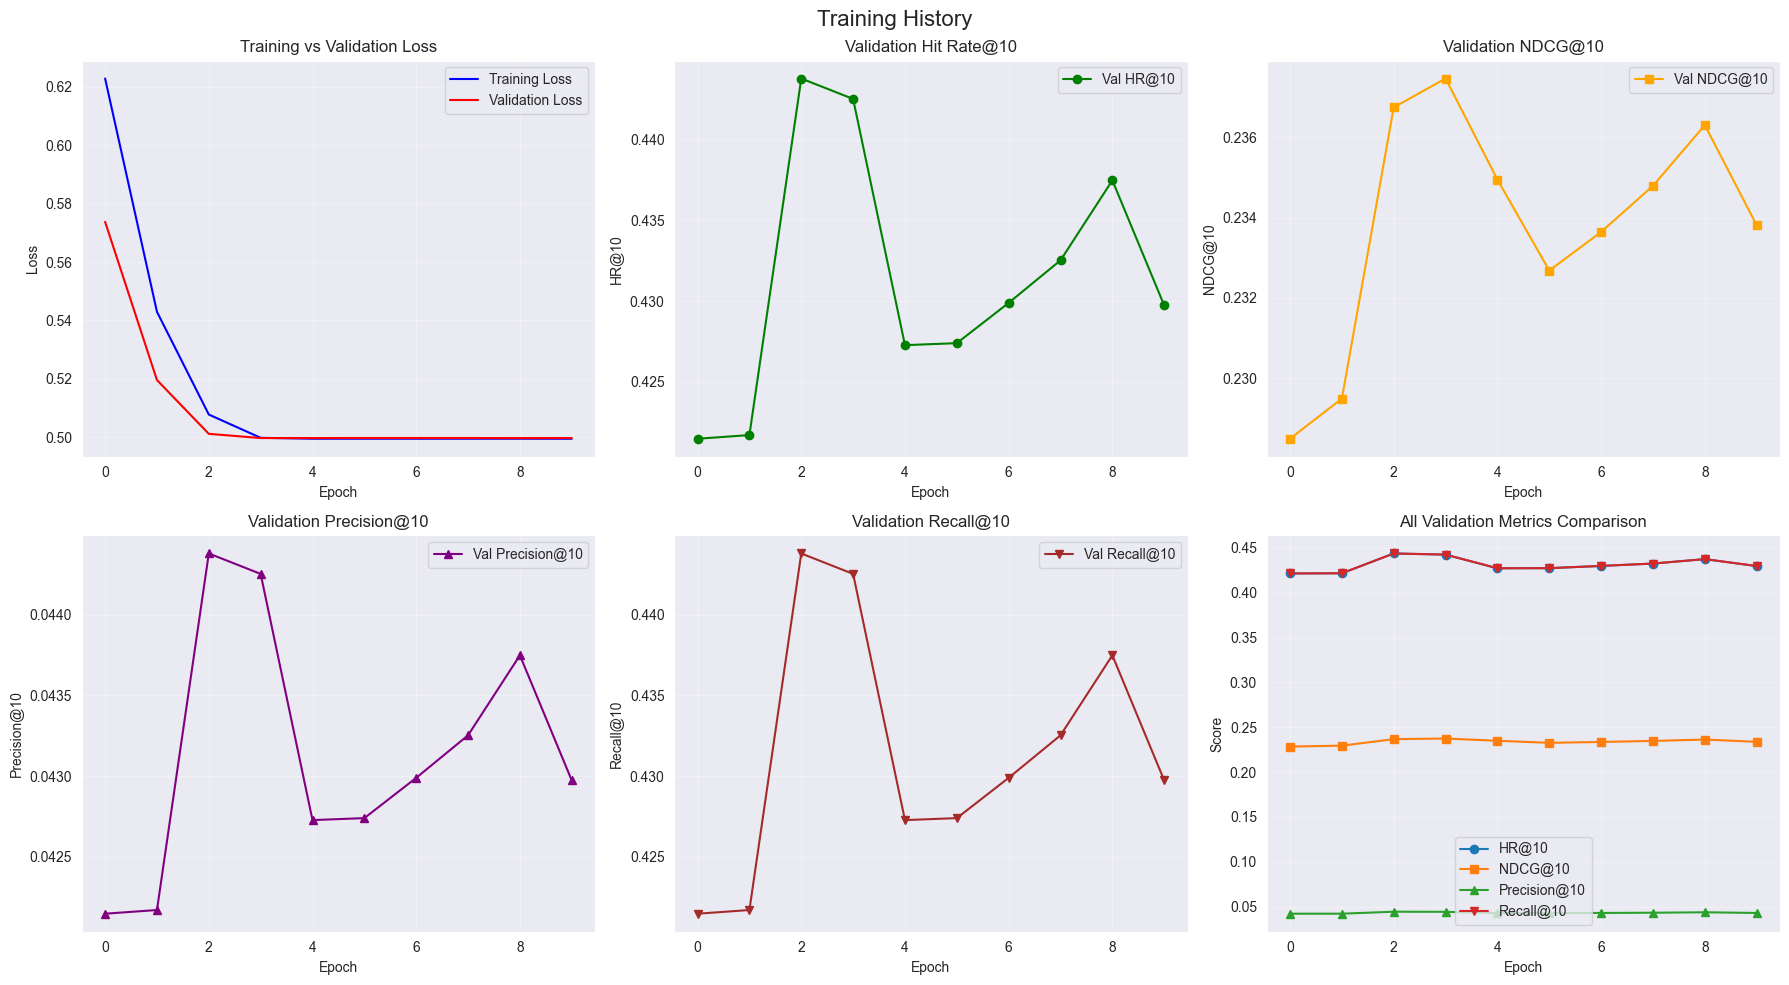

In [95]:
plot_training_history(train_losses, val_losses, val_metrics, save_path="training_history.png")